In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s, l
import matplotlib.pyplot as plt
from functools import reduce
import operator

In [4]:
df = pd.read_csv("datas/df_1122.csv")

In [30]:
# Define feature categories
binary_features = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'instant_bookable', 'shared_bathrooms', 'has_washer', 'has_dryer',
    'has_dishwasher', 'has_freezer', 'has_bbq_grill', 'has_hot_tub',
    'has_pool', 'has_gym', 'has_balcony', 'has_backyard'
]

# for col in df.columns:
#     if col.startswith("neighbourhood_") or col.startswith("location_"):
#         binary_features.append(col)


# Identify numerical and categorical features
numerical_features = [
    'latitude', 'longitude', 'host_listings_count', 'host_total_listings_count',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30',
    'availability_60', 'availability_90', 'availability_365', 'minimum_nights',
    'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm',
    'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'reviews_per_month',
    'description_length', 'name_length', 'host_since', 'first_review', 'last_review'
    # Include any additional numerical features like temporal features
]

# Define X and y
X = df.drop('price', axis=1)
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# Concatenate scaled numerical features with binary and one-hot encoded categorical features
# Assuming that the remaining features are one-hot encoded categorical features
categorical_features = [col for col in X.columns if col not in numerical_features + binary_features + ['price_bucket']]

X_train_final = np.hstack([
    X_train_num,
    X_train[binary_features].values,
    X_train[categorical_features].values
])

X_test_final = np.hstack([
    X_test_num,
    X_test[binary_features].values,
    X_test[categorical_features].values
])

In [32]:
# Identify indices for numerical and linear features
num_indices = list(range(len(numerical_features)))  # Indices for numerical features
linear_indices = list(range(len(numerical_features), X_train_final.shape[1]))  # Indices for binary and categorical features

# Define smooth terms for numerical features
smooth_terms = [s(i, n_splines=20) for i in num_indices]

# Define linear terms for binary and categorical features
linear_terms = [l(j) for j in linear_indices]

# Combine all terms using reduce and operator.add
all_terms = reduce(operator.add, smooth_terms + linear_terms)

# Initialize and fit the GAM model
gam = LinearGAM(all_terms).fit(X_train_final, y_train)


In [33]:
# Make continuous predictions
y_pred_continuous = gam.predict(X_test_final)

# Round predictions to the nearest integer
y_pred_rounded = np.round(y_pred_continuous).astype(int)

# Clip predictions to the valid range [0, 5]
y_pred_clipped = np.clip(y_pred_rounded, 0, 5)

# Calculate RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_clipped))
print(f"Final RMSE (GAM without binarization): {final_rmse:.4f}")


Final RMSE (GAM without binarization): 0.8618


In [34]:
# Define parameter grid for number of splines in numerical features
param_grid = {
    'n_splines': np.arange(10, 30, 5)
}

# Initialize GridSearchCV with GAM
gam_grid = GridSearchCV(
    LinearGAM,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit the grid search
gam_grid.fit(X_train_final, y_train)

# Best GAM model
best_gam = gam_grid.best_estimator_

# Predict and evaluate
y_pred_continuous_best = best_gam.predict(X_test_final)
y_pred_rounded_best = np.round(y_pred_continuous_best).astype(int)
y_pred_clipped_best = np.clip(y_pred_rounded_best, 0, 5)
final_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_clipped_best))
print(f"Final RMSE after GAM hyperparameter tuning: {final_rmse_best:.4f}")


TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

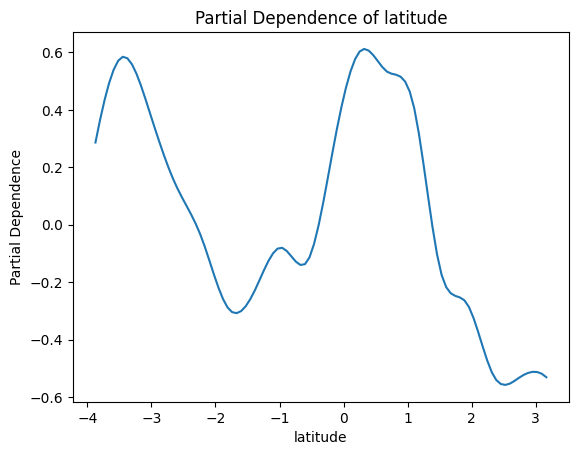

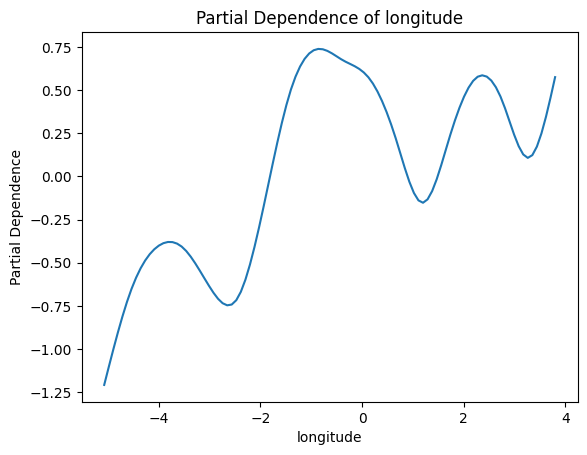

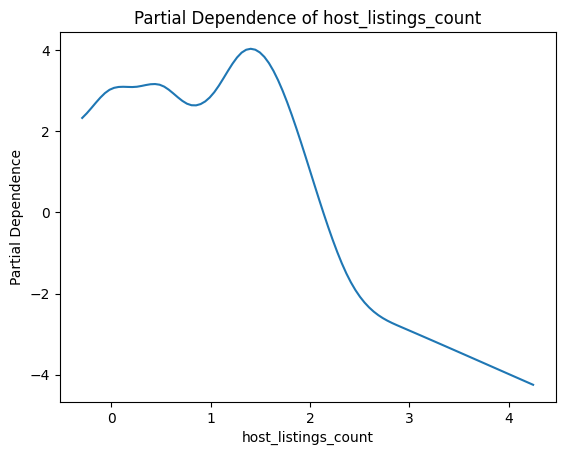

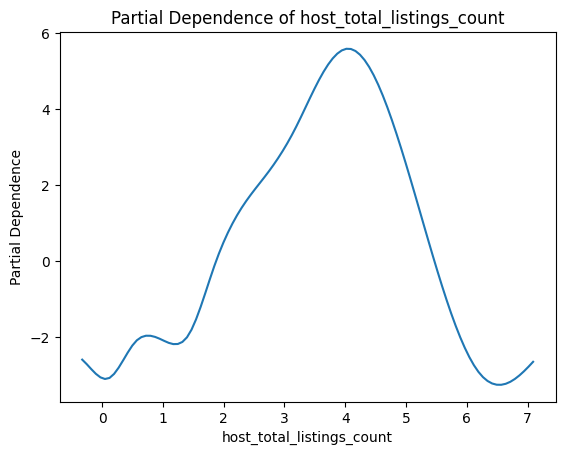

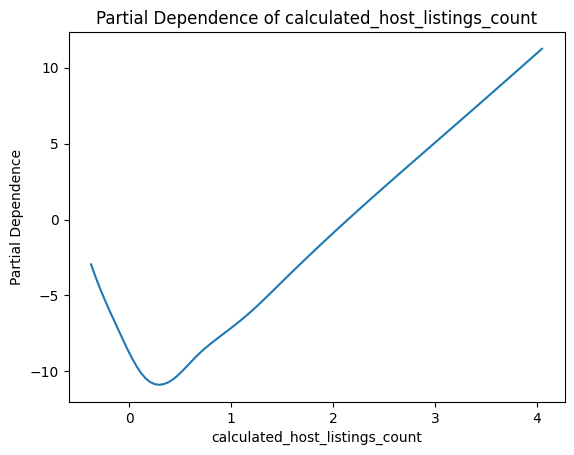

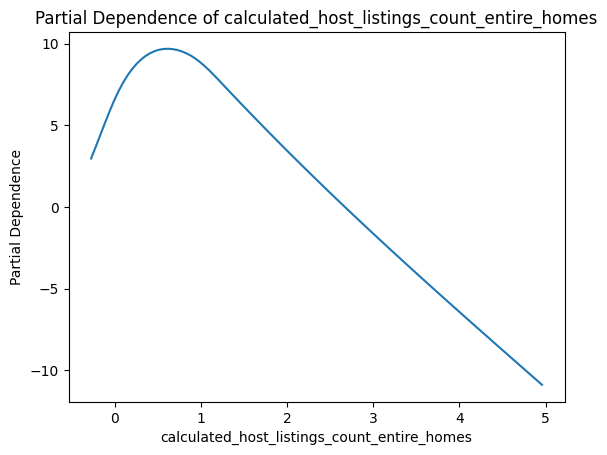

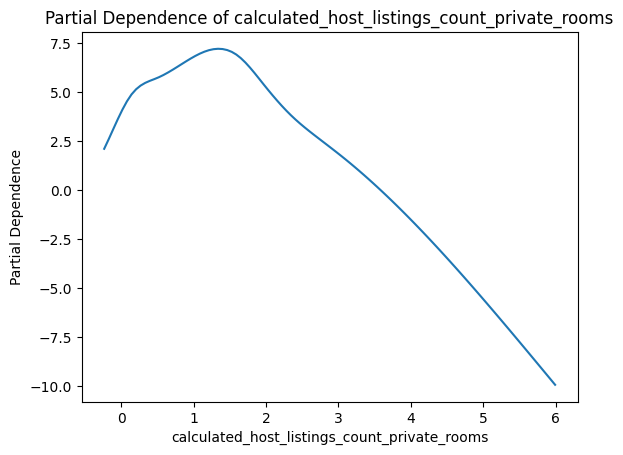

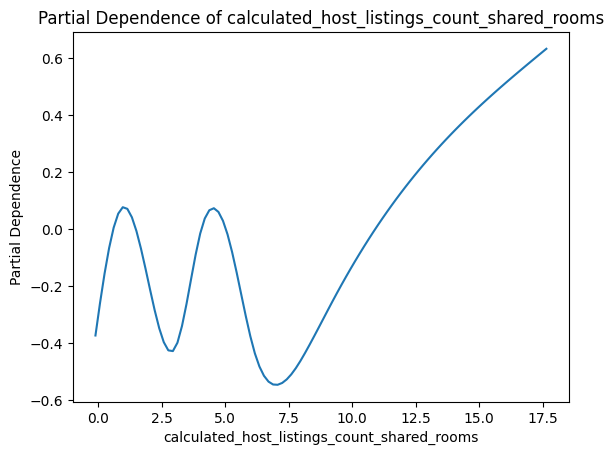

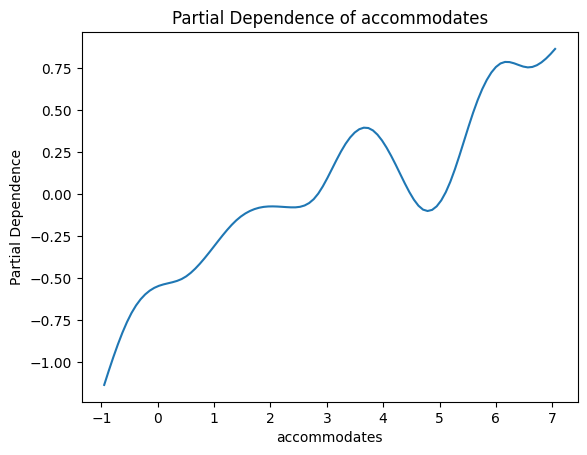

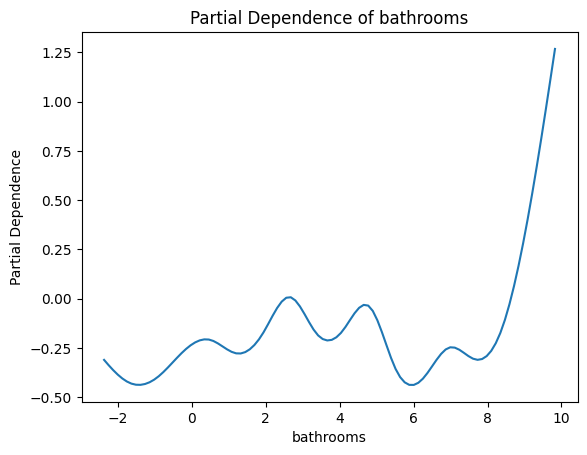

In [38]:
# Plot partial dependence for the first few numerical features
for i, feature in enumerate(numerical_features[:10]):  # Adjust as needed
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Partial Dependence of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Partial Dependence')
    plt.show()
